# Imports and Read-ins

In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime as dt
import re

In [142]:
members = pd.read_csv('data/NSS_GreatCare_Members.csv')
admissions = pd.read_csv('data/NSS_Hospital_Inpatient_Admissions.csv')
pcp = pd.read_csv('data/NSS_PrimaryCare_Office_Visits.csv')

C:\Users\jrior\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (3,5,17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Getting the House in Order

### Convert date columns to datetime dtype, NPI columns to categories

In [143]:
members['Patient Date of Birth'] = pd.to_datetime(members['Patient Date of Birth'], format='%Y-%m-%d')
members['Period Start Date'] = pd.to_datetime(members['Period Start Date'], format='%Y-%m-%d')
members['Period End Date'] = pd.to_datetime(members['Period End Date'], format='%Y-%m-%d')
members['Empirically Attributed PCP Individual Provider NPI'] = (members['Empirically Attributed PCP Individual Provider NPI']
                                                                .astype("string")
                                                                #.str.replace(".0","")
                                                                .astype("category"))
members['Empirically Attributed PCP Group Provider NPI'] = (members['Empirically Attributed PCP Group Provider NPI']
                                                                .astype("string")
                                                                #.str.replace(".0","")
                                                                .astype("category"))

In [144]:
admissions['Encounter Start Date'] = pd.to_datetime(admissions['Encounter Start Date'], format='%Y-%m-%d')
admissions['Encounter End Date'] = pd.to_datetime(admissions['Encounter End Date'], format='%Y-%m-%d')
admissions['Facility Provider NPI'] = (admissions['Facility Provider NPI'].astype("string")
                                       #.str.replace(".0","")
                                       .astype("category"))
admissions['Attending Provider NPI'] = (admissions['Attending Provider NPI'].astype("string")
                                        .str.replace("\.0","")
                                        .astype("category"))

<ipython-input-144-ea8517b1416f>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  admissions['Attending Provider NPI'] = (admissions['Attending Provider NPI'].astype("string")


In [145]:
pcp['Encounter Date'] = pd.to_datetime(pcp['Encounter Date'], format='%Y-%m-%d')
pcp['Service Provider NPI'] = (pcp['Service Provider NPI']
                               .astype("string")
                               .str.replace("\.0","")
                               .astype("category"))
pcp['Provider Group NPI'] = (pcp['Provider Group NPI']
                             .astype("string")
                             .str.replace("\.0","")
                             .astype("category"))

<ipython-input-145-054b4ec1f3ba>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  pcp['Service Provider NPI'] = (pcp['Service Provider NPI']
<ipython-input-145-054b4ec1f3ba>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  pcp['Provider Group NPI'] = (pcp['Provider Group NPI']


### Take select columns from the dataframes

In [146]:
memb = members[['Patient ID', 'Primary Plan ID', 'Patient Age Integer', 'Patient Date of Birth', 'Patient ZIP Code 5-Digit',
       'Empirically Attributed PCP Individual Provider NPI',
       'Empirically Attributed PCP Individual Provider Description',
       'Empirically Attributed PCP Group Provider NPI',
       'Empirically Attributed PCP Group Provider Description']]

In [147]:
adm = admissions[['Encounter ID', 'Patient ID', 'Attending Provider NPI',
       'Facility Provider NPI', 'Encounter Start Date', 'Encounter End Date',
       'Principal Discharge Diagnosis ICD-9-CM Code',
       'Principal Discharge Diagnosis ICD-9-CM Description',
       'Principal Discharge Diagnosis ICD-10-CM Code',
       'Principal Discharge Diagnosis ICD-10-CM Description',
       'Primary Plan Allowed Amount', 'Primary Plan Paid Amount',
       'Patient Paid Amount']]

In [148]:
#reduce pcp to relevant columns
pc = pcp[['Encounter ID','Patient ID', 'Attending Provider NPI', 'Service Provider NPI',
          'Provider Group NPI','Encounter Date']]                                                                     

# Problem 1: 30-day Readmission Rate

## Preparation: create Patient Adm Count

In [149]:
#count how many visits each patient has had up to and including current visit
adm['Patient Adm Count'] = adm.groupby('Patient ID')['Encounter Start Date'].transform('rank', method = 'first')

<ipython-input-149-e07c32f388a7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adm['Patient Adm Count'] = adm.groupby('Patient ID')['Encounter Start Date'].transform('rank', method = 'first')


## Self-join on Patient ID and Patient Adm Count

In [150]:
#Create new dataframe from admissions that only has three columns
readmits = adm[['Patient ID', 'Patient Adm Count', 'Encounter Start Date']]

#Add 1 to all patient_adm_ct. This transformation allows us to put the discharge date from the patient's previous hospital
#visit on the same line as their current visit, thus allowing us to calculate a difference in dates.
readmits['Patient Adm Count'] -= 1

#merge the two dataframes on patient id and the transformed patient_adm_ct
readmissions = pd.merge(adm, readmits, how = 'left', on = ['Patient ID', 'Patient Adm Count'], suffixes = ('', ' Next'))

#calculate the days of difference between next encounter's start date and the current encounter's end date
readmissions['Days Until Readmission'] = readmissions['Encounter Start Date Next'] - readmissions['Encounter End Date']

#create boolean 'Under 30 Days'
readmissions['Under 30 Days'] = (readmissions['Days Until Readmission'] >= dt.timedelta(days = 0)) & (readmissions['Days Until Readmission'] <= dt.timedelta(days = 30))

#Get 30-day readmission rate
#First pass at under-30-day rate.
under_30_d_rate = sum(readmissions['Under 30 Days'])/len(readmissions.index)
print(round(under_30_d_rate*100,2), '% readmitted under 30 days')

11.27 % readmitted under 30 days


<ipython-input-150-7ceb3e4dc286>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  readmits['Patient Adm Count'] -= 1


In [151]:
#checking my work
readmissions[readmissions['Patient Adm Count']>= 2].count()
readmissions['Patient Adm Count'].unique()
readmissions.groupby(['Patient ID', 'Patient Adm Count']).ngroups

6213

### Mean days between release and readmission

In [152]:
#mean readmission time
readmissions['Days Until Readmission'].mean()

Timedelta('104 days 20:28:34.285714286')

### 30-day readmission rates by month

    Encounter Month  Encounters Count  Under 30 Days Count  Under 30 Days Rate
98       2018-01-31                 2                    1           50.000000
101      2018-04-30                 3                    1           33.333333
87       2017-02-28                22                    6           27.272727
94       2017-09-30                11                    3           27.272727
93       2017-08-31                11                    3           27.272727
..              ...               ...                  ...                 ...
92       2017-07-31                 7                    0            0.000000
91       2017-06-30                 5                    0            0.000000
3        2010-02-28                30                    0            0.000000
114      2019-05-31                 1                    0            0.000000
112      2019-03-31                 0                    0                 NaN

[115 rows x 4 columns]


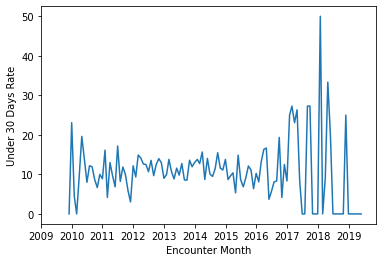

In [176]:
monthly_u30 = readmissions.groupby(pd.Grouper(key = 'Encounter End Date',freq='M'))['Under 30 Days'].sum()
monthly_u30 = pd.DataFrame({'Encounter Month':monthly_u30.index, 'Under 30 Days Count':monthly_u30.values})


monthly_encounters = readmissions.groupby(pd.Grouper(key = 'Encounter End Date',freq='M'))['Encounter ID'].count()
monthly_encounters = pd.DataFrame({'Encounter Month': monthly_encounters.index, 'Encounters Count': monthly_encounters.values})

monthly_u30_rates = pd.merge(monthly_encounters, monthly_u30, how = 'inner')

monthly_u30_rates['Under 30 Days Rate'] = 100*monthly_u30_rates['Under 30 Days Count'] / monthly_u30_rates['Encounters Count']

print(monthly_u30_rates.sort_values('Under 30 Days Rate', ascending = False))

g = sns.lineplot(x = 'Encounter Month', y = 'Under 30 Days Rate', data = monthly_u30_rates)
g.set(xlim = (pd.to_datetime('2008-12-31'),None))
plt.savefig('monthly_u30_rates_rough', transparent = True)

(array([14488., 14579., 14669., 14761., 14853., 14944., 15034., 15126.,
        15218., 15309., 15400., 15492., 15584., 15675., 15765., 15857.,
        15949., 16040., 16130., 16222., 16314., 16405., 16495., 16587.,
        16679., 16770., 16861., 16953., 17045., 17136., 17226., 17318.,
        17410., 17501., 17591., 17683., 17775., 17866., 17956., 18048.,
        18140.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 

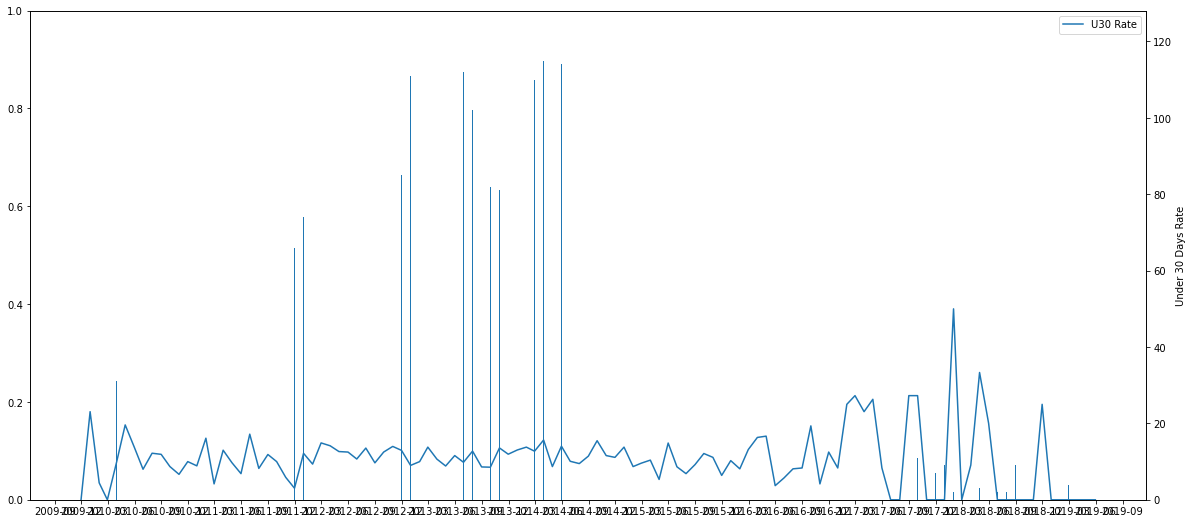

In [200]:
fig, ax1 = plt.subplots(figsize = (20,9))
ax2 = ax1.twinx()

ax1 = plt.bar(data = monthly_u30_rates, x = 'Encounter Month', height = 'Encounters Count')
ax2 = sns.lineplot(data = monthly_u30_rates, x = 'Encounter Month', y = 'Under 30 Days Rate', label = 'U30 Rate')

ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
#ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b - %y'))
plt.xticks(rotation = 90)

In [154]:
#Investigative: looks like there's one Encounter for 1996, and everything else is 2009 and later.
readmissions.groupby(pd.Grouper(key = 'Encounter End Date',freq='Y'))['Encounter ID'].count()

Encounter End Date
2009-12-31      28
2010-12-31     422
2011-12-31     806
2012-12-31    1160
2013-12-31    1208
2014-12-31    1234
2015-12-31     793
2016-12-31     366
2017-12-31     139
2018-12-31      50
2019-12-31       7
Freq: A-DEC, Name: Encounter ID, dtype: int64

# Problem 2: 7-day PCP Rate

## Merge readmissions and pcp, then clean until at most 1 pcp visit per hospital visit

In [155]:
#merger readmissions with pc
readm_pcp = pd.merge(readmissions, pc, how = 'left', on = 'Patient ID', suffixes = ('', ' PCP'))

#create timedelta column between hospital release and PCP visit (will have negatives)
readm_pcp['Hospital to PCP Days'] = readm_pcp['Encounter Date'] - readm_pcp['Encounter End Date']

#cut out all rows with negative time in Hospital to PCP Days, but keep na rows (people who never saw PCP)
readm_pcp = readm_pcp[(readm_pcp['Hospital to PCP Days'] >= dt.timedelta(days = 0)) | (readm_pcp['Hospital to PCP Days'].isnull())]

#Keep people who never saw PCP and rows where Hospital to PCP Days is minimized by Patient ID and patient_adm_ct
readm_pcp = readm_pcp[readm_pcp['Hospital to PCP Days'].isnull() 
                      | 
                      (readm_pcp['Hospital to PCP Days'] == readm_pcp.groupby(['Patient ID', 'Patient Adm Count'])['Hospital to PCP Days'].transform('min'))]

#create boolean column for PCP visits within 7 days
readm_pcp['PCP Under 7 Days'] = readm_pcp['Hospital to PCP Days'] <= dt.timedelta(days = 7)

# merge to new re_pcp dataframe, fill NAs with False
re_pcp = pd.merge(readmissions, readm_pcp, how = 'left')
re_pcp['PCP Under 7 Days'] = re_pcp['PCP Under 7 Days'].fillna(False)

re_pcp

,Encounter ID,Patient ID,Attending Provider NPI,Facility Provider NPI,Encounter Start Date,Encounter End Date,Principal Discharge Diagnosis ICD-9-CM Code,Principal Discharge Diagnosis ICD-9-CM Description,Principal Discharge Diagnosis ICD-10-CM Code,Principal Discharge Diagnosis ICD-10-CM Description,...,Encounter Start Date Next,Days Until Readmission,Under 30 Days,Encounter ID PCP,Attending Provider NPI PCP,Service Provider NPI,Provider Group NPI,Encounter Date,Hospital to PCP Days,PCP Under 7 Days
0,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,1417170523,1306890389,2013-01-12,2013-01-14,NaN,NaN,O70.0,First degree perineal laceration during delivery,...,NaT,NaT,False,COV|PCSL|DS1|10033|P|711310|1043427248|1,NaN,1619980406,1043427248,2014-02-16,398 days,False
1,HIA|DS1|10043|DS1|NPI|1902803315|1,DS1|10043,1669599197,1902803315,2014-01-05,2014-01-12,348.4,Compression of brain,NaN,NaN,...,NaT,NaT,False,COV|PBSL|DS1|10043|P|538933|1043427248|1|SHIFTED,NaN,1619199791,1043427248,2014-01-12,0 days,True
2,HIA|DS1|10073|DS1|NPI|1902803315|1,DS1|10073,1407880511,1902803315,2012-06-13,2012-06-21,NaN,NaN,K91.71,Accidental puncture and laceration of a digest...,...,NaT,NaT,False,COV|PBSL|DS1|10073|P|301709|1043427248|1|SHIFTED,NaN,1659394021,1043427248,2012-06-27,6 days,True
3,HIA|DS1|10101|DS1|NPI|1427055839|1,DS1|10101,1407008907,1427055839,2012-12-06,2012-12-09,NaN,NaN,O70.1,Second degree perineal laceration during delivery,...,NaT,NaT,False,COV|PCSL|DS1|10101|P|1189971|1043427248|1,NaN,1952538340,1043427248,2012-12-12,3 days,True
4,HIA|DS1|10118|DS1|NPI|1992818256|1,DS1|10118,1518045608,1992818256,2015-03-11,2015-03-14,NaN,NaN,F32.9,"Major depressive disorder, single episode, uns...",...,NaT,NaT,False,COV|PCSL|DS1|10118|P|486026|1043427248|1,NaN,1316361942,1043427248,2015-11-04,235 days,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6209,HIA|DS1|9979|DS1|NPI|1689772592|1,DS1|9979,1720043417,1689772592,2015-02-06,2015-02-11,NaN,NaN,O44.13,"Complete placenta previa with hemorrhage, thir...",...,NaT,NaT,False,COV|PCSL|DS1|9979|P|281365|1477666352|1,NaN,1740277995,1477666352,2015-02-15,4 days,True
6210,HIA|DS1|9981|DS1|NPI|1427055839|1,DS1|9981,1215968474,1427055839,2014-08-07,2014-08-10,664.11,"Second-degree perineal laceration, delivered, ...",NaN,NaN,...,NaT,NaT,False,COV|PCSL|DS1|9981|P|1094367|1043427248|1,NaN,1992932388,1043427248,2014-08-11,1 days,True
6211,HIA|DS1|9994|DS1|NPI|1689608150|1,DS1|9994,1861831836,1689608150,2015-11-21,2015-11-23,NaN,NaN,O76,Abnormality in fetal heart rate and rhythm com...,...,2015-11-24,1 days,True,COV|PCSL|DS1|9994|P|1238517|1407058787|2,NaN,1487734547,1407058787,2015-12-05,12 days,False
6212,HIA|DS1|9994|DS1|NPI|1689608150|2,DS1|9994,1750544516,1689608150,2015-11-24,2015-11-27,NaN,NaN,O42.92,"Full-term premature rupture of membranes, unsp...",...,NaT,NaT,False,COV|PCSL|DS1|9994|P|1238517|1407058787|2,NaN,1487734547,1407058787,2015-12-05,8 days,False


In [156]:
# THIS CODE IS FOR CHECKING AND DATA CLEANING
# print(round(sum(readm_pcp['PCP Under 7 Days'])*100/len(readmissions), 2), '% see PCP within 7 days of hospital release.')
# sum(readm_pcp['PCP Under 7 Days'])

In [157]:
#Note this weird extra row that's been created with the merge back.
#The difference between these two rows: Had two different follow-ups within same day.
#Should only count as one hospital Encounter admission and only as one PCP follow-up
#re_pcp[re_pcp.duplicated(subset='Encounter ID', keep=False)]

In [158]:
#Under 7-days PCP visit rate
print(round(100*(sum(re_pcp['PCP Under 7 Days'])-re_pcp.duplicated(subset = 'Encounter ID').sum())/len(re_pcp['Encounter ID'].unique()),2), '% of admissions see PCP within 7 days of hospital release.')

30.0 % of admissions see PCP within 7 days of hospital release.


In [159]:
#numerator check
sum(re_pcp['PCP Under 7 Days'])-re_pcp.duplicated(subset = 'Encounter ID').sum()

1864

### Mean Hospital-to-PCP days

In [160]:
re_pcp['Hospital to PCP Days'].mean()

Timedelta('106 days 07:57:22.527339004')

### PCP rates by month

    Encounter Month  Encounters Count  Under 7 Days Count    u7d_rate
0        2009-11-30                 2                   0    0.000000
1        2009-12-31                26                   8   30.769231
2        2010-01-31                45                  14   31.111111
3        2010-02-28                30                  13   43.333333
4        2010-03-31                31                   9   29.032258
..              ...               ...                 ...         ...
110      2019-01-31                 1                   1  100.000000
111      2019-02-28                 4                   2   50.000000
112      2019-03-31                 0                   0         NaN
113      2019-04-30                 1                   0    0.000000
114      2019-05-31                 1                   0    0.000000

[115 rows x 4 columns]


[(14244.0, 18220.45)]

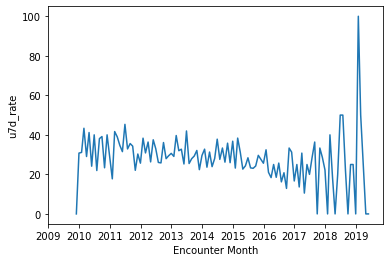

In [161]:
monthly_u7 = re_pcp.groupby(pd.Grouper(key = 'Encounter End Date',freq='M'))['PCP Under 7 Days'].sum()
monthly_u7 = pd.DataFrame({'Encounter Month':monthly_u7.index, 'Under 7 Days Count':monthly_u7.values})


monthly_encounters = readmissions.groupby(pd.Grouper(key = 'Encounter End Date',freq='M'))['Encounter ID'].count()
monthly_encounters = pd.DataFrame({'Encounter Month': monthly_encounters.index, 'Encounters Count': monthly_encounters.values})

monthly_u7_rates = pd.merge(monthly_encounters, monthly_u7, how = 'inner')

monthly_u7_rates['u7d_rate'] = 100*monthly_u7_rates['Under 7 Days Count'] / monthly_u7_rates['Encounters Count']

print(monthly_u7_rates)

g = sns.lineplot(x = 'Encounter Month', y = 'u7d_rate', data = monthly_u7_rates)
g.set(xlim = (pd.to_datetime('2008-12-31'),None))

# Problem 3
## Part A: Does 30-day readmission rate vary by hospital?

In [162]:
# For each facility NPI, calculate a sum of readmissions within 30 days
# divided by the number of admissions to that facility NPI
facility_u30_ct = readmissions.groupby('Facility Provider NPI', as_index = False)['Under 30 Days'].sum()
encounters_by_facility = readmissions.groupby('Facility Provider NPI', as_index = False)['Encounter ID'].count()

facility_u30 = pd.merge(encounters_by_facility, facility_u30_ct, how = 'left')

facility_u30['Facility U30 Days Rate'] = 100*facility_u30['Under 30 Days']/facility_u30['Encounter ID']
facility_u30
fac_u30_sum = facility_u30[facility_u30['Encounter ID'] >= 10].sort_values('Facility U30 Days Rate', ascending = False).head(9).reset_index(drop=True)
fac_u30_sum

,Facility Provider NPI,Encounter ID,Under 30 Days,Facility U30 Days Rate
0,1952546616,10,7,70.000000
1,1265814065,11,4,36.363636
2,1336328244,10,3,30.000000
3,1841277704,11,3,27.272727
4,1770532608,11,3,27.272727
5,1639172372,20,4,20.000000
6,1467459776,16,3,18.750000
7,1053351916,11,2,18.181818
8,1811080526,22,4,18.181818


<BarContainer object of 9 artists>

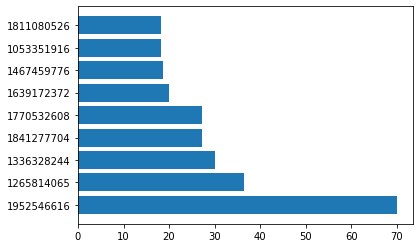

In [163]:
#sns.barplot(x = 'Facility U30 Days Rate', y = 'Facility Provider NPI', data = fac_u30_sum, orient = 'v')
plt.barh(data = fac_u30_sum, width = 'Facility U30 Days Rate', y = 'Facility Provider NPI')

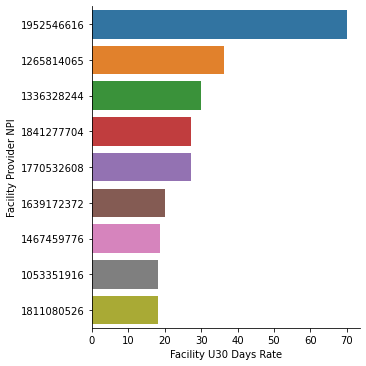

In [164]:
sns.catplot(data = facility_u30[facility_u30['Encounter ID'] >= 10], 
            x = 'Facility U30 Days Rate', 
            y = 'Facility Provider NPI', 
            kind = 'bar', 
            order = (facility_u30[facility_u30['Encounter ID'] >= 10].
                     sort_values('Facility U30 Days Rate', ascending = False)['Facility Provider NPI'].
                     head(9))
           )

## Part B: Does 30-day readmission rate vary by hospital physician?

In [165]:
att_u30_ct = readmissions.groupby('Attending Provider NPI', as_index = False)['Under 30 Days'].sum()
encounters_by_att = readmissions.groupby('Attending Provider NPI', as_index = False)['Encounter ID'].count()

att_u30 = pd.merge(encounters_by_att, att_u30_ct, how = 'left')

att_u30['Attending Provider U30 Days Rate'] = 100*att_u30['Under 30 Days']/att_u30['Encounter ID']
att_u30
att_u30_sum = att_u30[att_u30['Encounter ID'] >= 10].sort_values('Attending Provider U30 Days Rate', ascending = False).head(10)
att_u30_sum

,Attending Provider NPI,Encounter ID,Under 30 Days,Attending Provider U30 Days Rate
1130,1568574937,12,4,33.333333
497,1245477652,11,3,27.272727
1794,1932230810,12,3,25.000000
1332,1679541775,34,8,23.529412
814,1417061797,39,8,20.512821
471,1235174103,10,2,20.000000
20,1013113679,10,2,20.000000
112,1053358127,25,5,20.000000
574,1295768638,16,3,18.750000
162,1073566931,22,4,18.181818


<BarContainer object of 10 artists>

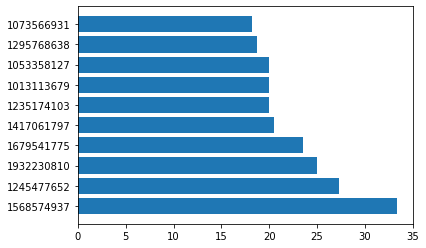

In [166]:
plt.barh(data = att_u30_sum, width = 'Attending Provider U30 Days Rate', y = 'Attending Provider NPI')

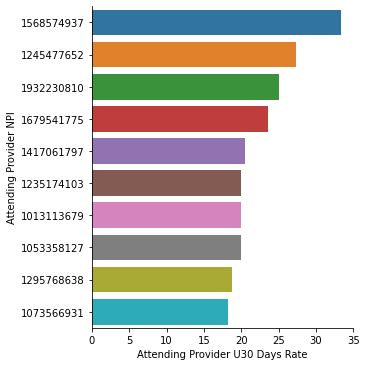

In [167]:
sns.catplot(data = att_u30_sum, 
            x = 'Attending Provider U30 Days Rate', 
            y = 'Attending Provider NPI', 
            kind = 'bar', 
            order = (att_u30_sum.
                     sort_values('Attending Provider U30 Days Rate', ascending = False)['Attending Provider NPI'].
                     head(10))
           )

## Part C: Does 7-day follow-up rate vary by group PCP?

In [168]:
pcp_u7_by_group = re_pcp.groupby('Provider Group NPI', as_index = False)['PCP Under 7 Days'].sum()
encounters_by_pcp_group = re_pcp.groupby('Provider Group NPI', as_index = False)['Encounter ID'].count()

pcp_group_u7 = pd.merge(encounters_by_pcp_group, pcp_u7_by_group, how = 'left')

pcp_group_u7['PCP Group U7 Days Rate'] = 100*pcp_group_u7['PCP Under 7 Days']/pcp_group_u7['Encounter ID']
pcp_group_u7
pcp_group_u7[pcp_group_u7['Encounter ID'] >= 10].sort_values("PCP Group U7 Days Rate", ascending = False).head(50)

,Provider Group NPI,Encounter ID,PCP Under 7 Days,PCP Group U7 Days Rate
95,1245579655,11,10,90.909091
92,1235187311,19,13,68.421053
146,1386637346,15,9,60.000000
70,1164512851,481,212,44.074844
200,1518947167,19,8,42.105263
82,1205884392,31,13,41.935484
33,1083694616,17,7,41.176471
347,1912987553,108,44,40.740741
59,1144213166,25,10,40.000000
20,1043427248,2209,842,38.116795


## Part D: Does 7-day follow-up rate vary by PCP physician?

In [169]:
pcp_u7_by_provider = re_pcp.groupby('Service Provider NPI', as_index = False)['PCP Under 7 Days'].sum()
encounters_by_pcp_provider = re_pcp.groupby('Service Provider NPI', as_index = False)['Encounter ID'].count()

pcp_provider_u7 = pd.merge(encounters_by_pcp_provider, pcp_u7_by_provider, how = 'left')

pcp_provider_u7['PCP Provider U7 Days Rate'] = 100*pcp_provider_u7['PCP Under 7 Days']/pcp_provider_u7['Encounter ID']
pcp_provider_u7.sort_values("Encounter ID", ascending = False)

,Service Provider NPI,Encounter ID,PCP Under 7 Days,PCP Provider U7 Days Rate
277,1104884337,66,41,62.121212
1876,1619980406,52,18,34.615385
3012,1972704856,50,12,24.000000
1391,1467643700,50,28,56.000000
1276,1437180965,49,28,57.142857
...,...,...,...,...
1630,1538495973,0,0,NaN
1629,1538484084,0,0,NaN
1628,1538480686,0,0,NaN
1627,1538435417,0,0,NaN


## Bonus: Readmissions Data Analyzed by Members

In [170]:
#df merge: members and readmissions
remembpcp = pd.merge(re_pcp, memb, how = 'left', on = 'Patient ID')
remembpcp

,Encounter ID,Patient ID,Attending Provider NPI,Facility Provider NPI,Encounter Start Date,Encounter End Date,Principal Discharge Diagnosis ICD-9-CM Code,Principal Discharge Diagnosis ICD-9-CM Description,Principal Discharge Diagnosis ICD-10-CM Code,Principal Discharge Diagnosis ICD-10-CM Description,...,Hospital to PCP Days,PCP Under 7 Days,Primary Plan ID,Patient Age Integer,Patient Date of Birth,Patient ZIP Code 5-Digit,Empirically Attributed PCP Individual Provider NPI,Empirically Attributed PCP Individual Provider Description,Empirically Attributed PCP Group Provider NPI,Empirically Attributed PCP Group Provider Description
0,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,1417170523,1306890389,2013-01-12,2013-01-14,NaN,NaN,O70.0,First degree perineal laceration during delivery,...,398 days,False,DS1|5047X,1,2012-11-09,94123.0,1225216351.0,"CLIMACO, ANNE MAE B.",1043427248.0,UCLA MEDICAL GROUP
1,HIA|DS1|10043|DS1|NPI|1902803315|1,DS1|10043,1669599197,1902803315,2014-01-05,2014-01-12,348.4,Compression of brain,NaN,NaN,...,0 days,True,DS1|5047Y,34,1979-12-28,90307.0,1619199791.0,"CANALE, STEPHANIE .",1043427248.0,UCLA MEDICAL GROUP
2,HIA|DS1|10073|DS1|NPI|1902803315|1,DS1|10073,1407880511,1902803315,2012-06-13,2012-06-21,NaN,NaN,K91.71,Accidental puncture and laceration of a digest...,...,6 days,True,DS1|5047X,64,1946-01-07,92122.0,NaN,NaN,NaN,NaN
3,HIA|DS1|10101|DS1|NPI|1427055839|1,DS1|10101,1407008907,1427055839,2012-12-06,2012-12-09,NaN,NaN,O70.1,Second degree perineal laceration during delivery,...,3 days,True,DS1|5047W,11,2003-01-25,90278.0,1801189048.0,"KO, ELIZABETH .",1043427248.0,UCLA MEDICAL GROUP
4,HIA|DS1|10118|DS1|NPI|1992818256|1,DS1|10118,1518045608,1992818256,2015-03-11,2015-03-14,NaN,NaN,F32.9,"Major depressive disorder, single episode, uns...",...,235 days,False,DS1|5047W,1,2012-08-12,94118.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6209,HIA|DS1|9979|DS1|NPI|1689772592|1,DS1|9979,1720043417,1689772592,2015-02-06,2015-02-11,NaN,NaN,O44.13,"Complete placenta previa with hemorrhage, thir...",...,4 days,True,DS1|5047X,39,1979-10-19,94404.0,NaN,NaN,NaN,NaN
6210,HIA|DS1|9981|DS1|NPI|1427055839|1,DS1|9981,1215968474,1427055839,2014-08-07,2014-08-10,664.11,"Second-degree perineal laceration, delivered, ...",NaN,NaN,...,1 days,True,DS1|5047W,33,1981-03-01,94116.0,NaN,NaN,NaN,NaN
6211,HIA|DS1|9994|DS1|NPI|1689608150|1,DS1|9994,1861831836,1689608150,2015-11-21,2015-11-23,NaN,NaN,O76,Abnormality in fetal heart rate and rhythm com...,...,12 days,False,DS1|5047W,37,1976-04-07,92126.0,1669552832.0,"NGUYEN, LAN T.",1205884392.0,UCI DEPARTMENT OF MEDICINE
6212,HIA|DS1|9994|DS1|NPI|1689608150|2,DS1|9994,1750544516,1689608150,2015-11-24,2015-11-27,NaN,NaN,O42.92,"Full-term premature rupture of membranes, unsp...",...,8 days,False,DS1|5047W,37,1976-04-07,92126.0,1669552832.0,"NGUYEN, LAN T.",1205884392.0,UCI DEPARTMENT OF MEDICINE


# Addenda: NOTHING AFTER THIS IS FOR PROJECT USE

## Problem 1: Method 2: for-loop over iterrows()

In [171]:
days_till_readmission = []
for index, row in adm.iterrows():
    if row['Patient Adm Count'] == 1:
        readm_time = pd.to_datetime(None)
    else:
        readm_time = (row['Encounter Start Date'] - adm[(adm['Patient ID'] == row['Patient ID'])
                                &
                                (adm['Patient Adm Count'] == row['Patient Adm Count']-1)]['Encounter End Date']).dt.days.values[0]
    days_till_readmission.append(readm_time)
    
days_till_readmission    
# admissions['days_till_readmission'] = days_till_readmission
# admissions['days_till_readmission'] = admissions['days_till_readmission'].dt.days
# print(admissions['days_till_readmission'])

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 135,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 496,
 47,
 None,
 None,
 285,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 126,
 None,
 31,
 0,
 5,
 47,
 25,
 28,
 73,
 27,
 27,
 4,
 None,
 None,
 None,
 None,
 None,
 None,
 4,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 0,
 None,
 None,
 674,
 None,
 78,
 -19,
 -2,
 17,
 None,
 None,
 None,
 None,
 151,
 19,
 222,
 0,
 None,
 None,
 116,
 95,
 105,
 None,
 None,
 None,
 111,
 125,
 None,
 None,
 None,
 0,
 None,
 None,
 None,
 None,
 301,
 None,
 None,
 None,
 47,
 None,
 None,
 None,
 None,
 139,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 590,
 None,
 None,
 None,
 364,
 1,
 None,
 70,
 157,
 38,
 47,
 6,
 None,
 647,
 None,
 None,
 None,
 None,
 None,
 None,
 10,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 No

## Checking My Work

In [172]:
#Checking for number of encounters picked up by each aggregation in Problem 3 (Note difference from 6213)
print(facility_u30['Encounter ID'].sum())
print(att_u30['Encounter ID'].sum())
print(pcp_group_u7['Encounter ID'].sum())
print(pcp_provider_u7['Encounter ID'].sum())

6213
5884
4840
4926
